# scaling european regions with higher annual global temp

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy as cart
import cartopy.crs as ccrs
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy as cart
import seaborn as sns
from scipy import stats
import geopandas as gp
from cartopy import util
import pyreadr
import sys
import datetime
import os

Data locations

In [7]:
folder = "/your/path/to/project/folder/"
loc_cmip = folder+"Data/CMIP6/"
loc_eobs = folder+"Data/E-OBS/"
loc_shp = folder+"Data/NUTS_RG_60M_2021_3035.shp/"
loc_figs = folder+"Figures/"

Shapefile

In [8]:
eu_shp = gp.read_file(loc_shp)
eu_shp = eu_shp.to_crs(4269)
eu_shp_nuts3 = eu_shp.loc[eu_shp.LEVL_CODE==3,:]
eu_shp_nuts1 = eu_shp.loc[(eu_shp.LEVL_CODE==1)&(eu_shp.CNTR_CODE=="DE"),:] # germany
eu_shp_nuts0 = eu_shp.loc[eu_shp.LEVL_CODE==0,:]

Read CMIP6 data

In [9]:
scen = "ssp370"
cmip6_eu = xr.open_dataset(loc_cmip+"CMIP6_historical_"+scen+"_europe_nuts3_mean_temperature_popweight_1850-2100.nc")

gmst and running mean eu regions

In [11]:
y1_clm = 1850
y2_clm = 1900
gmst = cmip6_eu.gmst - cmip6_eu.gmst.loc[:,y1_clm:y2_clm].mean(dim="time")

In [12]:
y1_clm_tm = 2000
y2_clm_tm = 2020
eu_tmean = cmip6_eu.temp_nuts - cmip6_eu.temp_nuts.loc[:,:,y1_clm_tm:y2_clm_tm].mean(dim="time")
eu_tmean_running = eu_tmean.rolling(time=20,center=False,min_periods=20).mean()
#eu_tmean_running = eu_tmean.rolling(time=20,center=True,min_periods=20).mean()
gmst_running = gmst.rolling(time=20,center=False,min_periods=20).mean()

Analysis

In [13]:
y1 = 2020
y2 = 2100

In [17]:
gmst_final = gmst.loc[:,y1:y2]
#gmst_final = gmst_running.loc[:,y1:y2]
# limit eu to prior years
# that is we want X to be GMT in 2100 and Y to be nuts3 temp in 2079-2099
eu_final = eu_tmean_running.loc[:,:,(y1-1):(y2-1)] 

Select nuts regions and plot

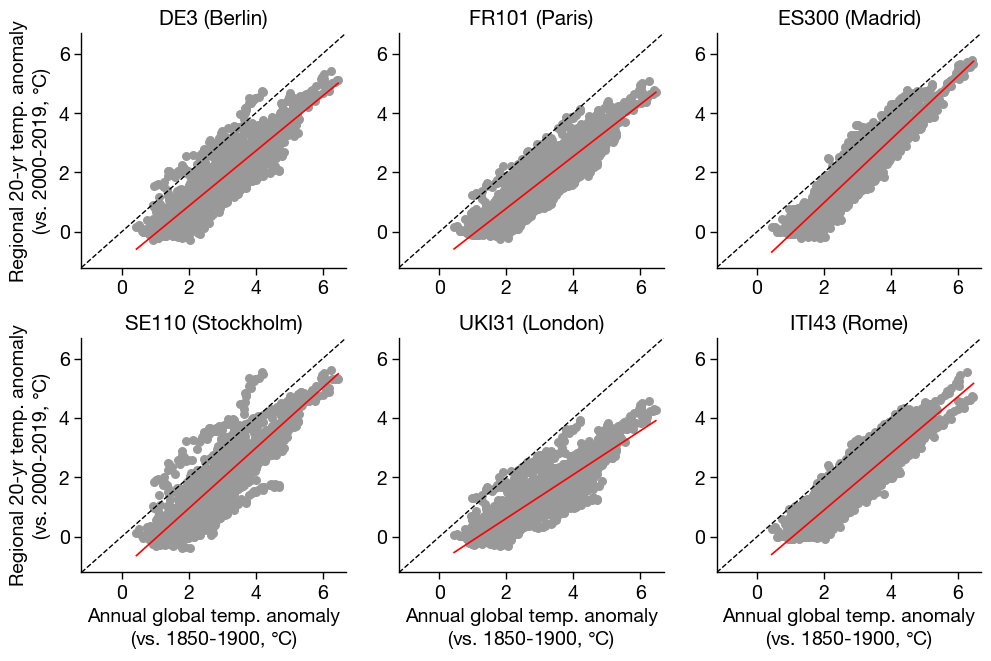

In [18]:
fig = plt.figure(figsize=(10,6.5))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs0 = gridspec.GridSpec(2,3)
left = 0.08
right = 0.98
bottom = 0.12
gs0.update(left=left,right=right,top=0.95,bottom=bottom,wspace=0.2,hspace=0.3)

tfs = 15
lbfs = 19
lbx = -0.1
lby = 1.06

nuts_list = ["DE3","FR101","ES300","SE110","UKI31","ITI43"]
nuts_names = ["DE3 (Berlin)","FR101 (Paris)","ES300 (Madrid)",\
              "SE110 (Stockholm)","UKI31 (London)","ITI43 (Rome)"]

for nuts in nuts_list:
    nn = nuts_list.index(nuts)

    ax = plt.subplot(gs0[nn])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    y = eu_final.loc[:,nuts,:].values.flatten()
    x = gmst_final.values.flatten()
    
    plt.scatter(x,y,s=30,color=[0.6,0.6,0.6],zorder=1)
    
    plt.xlim([-1.2,6.7])
    plt.ylim([-1.2,6.7])
    plt.plot([-1.2,6.7],[-1.2,6.7],linewidth=1,linestyle="--",color="black",zorder=2)
    if nn>2:
        plt.xlabel("Annual global temp. anomaly\n(vs. 1850-1900, $\degree$C)")

    if nn in [0,3]:
        plt.ylabel("Regional 20-yr temp. anomaly\n(vs. 2000-2019, $\degree$C)")

    sns.regplot(x=x,y=y,color="red",scatter=False,ci=True,line_kws={"linewidth":1.2})
    plt.title(nuts_names[nn],fontsize=tfs)

plt.savefig(loc_figs+"FigX_NUTS_Scaling.pdf")
plt.show()

Do regression for each region

In [19]:
n_reg = 100
nuts = cmip6_eu.nuts.values
coefs = xr.DataArray(np.full((2,n_reg,len(nuts)),np.nan),
                    coords=[["slope","intercept"],np.arange(1,n_reg+1,1),nuts],
                     dims=["coef","sample","nuts"])

In [20]:
x = gmst_final.values.flatten()
inds = np.arange(0,len(x),1)
np.random.seed(100)
for i in np.arange(1,n_reg+1,1):
    if np.mod(i,10)==0:
        print(i)
    sample_ind = np.random.choice(inds,size=len(inds),replace=True)
    xs = x[sample_ind]
    for n in nuts:
        y = eu_final.loc[:,n,:].values.flatten()
        ys = y[sample_ind]
        reg = np.polyfit(xs,ys,deg=1)
        coefs.loc["slope",i,n] = reg[0]
        coefs.loc["intercept",i,n] = reg[1]

10
20
30
40
50
60
70
80
90
100


Write out

In [21]:
coefs.name = "coefs"
coefs.attrs["creation_date"] = str(datetime.datetime.now())
coefs.attrs["created_by"] = "Christopher Callahan, christophercallahan@stanford.edu"
coefs.attrs["variable_description"] = "slope and intercept coefficients for each year's GMT vs. previous 20 year regional tmean change"
coefs.attrs["created_from"] = os.getcwd()+"/CMIP6_Adaptation_Scaling.ipynb"
fname_out = loc_cmip+"CMIP6_nuts3_global_regional_linear_scaling.nc"
coefs.to_netcdf(fname_out,mode="w")

Draw a map of the slope coefficients

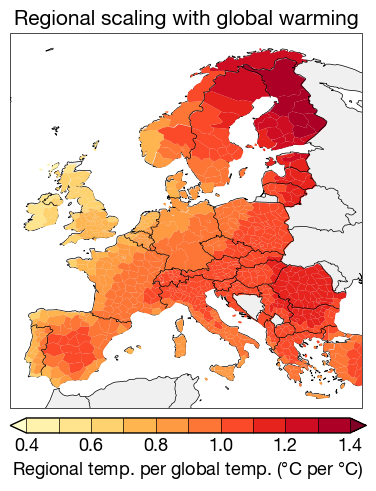

In [29]:
fig = plt.figure(figsize=(4,5))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs0 = gridspec.GridSpec(1,1)
left = 0.06
right = 0.98
bottom = 0.18
gs0.update(left=left,right=right,top=0.93,bottom=bottom,wspace=0.2,hspace=0.3)

latmin = 34
latmax = 73
lonmin = 349
lonmax = 30
bds = [lonmin-360,lonmax,latmin,latmax]
ax = plt.subplot(gs0[0,0],projection=ccrs.Robinson())
ax.set_extent(bds,crs=ccrs.PlateCarree())
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.title("Regional scaling with global warming",fontsize=tfs)

# colorbar
tmin = 0.4
tmax = 1.4
nrange = 11
bounds = np.linspace(tmin,tmax,nrange)
cm = "YlOrRd" #RdYlBu_r"
cols = plt.get_cmap(cm)(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap) 

# features
ax.add_feature(cart.feature.LAND, edgecolor="black",facecolor=[0.94,0.94,0.94],
                     zorder=4,linewidth=0.5)
ax.add_feature(cart.feature.BORDERS, edgecolor="black",
                     zorder=7,linewidth=0.5)

nuts_scaling = coefs.loc["slope",:,:].mean(dim="sample")

# draw regions
for i in np.arange(0,len(eu_shp_nuts3.NUTS_ID),1):
    nuts = eu_shp_nuts3.NUTS_ID.values[i]
    geom = eu_shp_nuts3.loc[eu_shp_nuts3.NUTS_ID==nuts,"geometry"]
    if "DE" not in nuts:
        val = nuts_scaling.loc[nuts]
        if val!=0:
            col = cbar.to_rgba(val)
            ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                                edgecolor="black",linewidth=0,zorder=6,alpha=1)

for i in np.arange(0,len(eu_shp_nuts1.NUTS_ID),1):
    nuts = eu_shp_nuts1.NUTS_ID.values[i]
    geom = eu_shp_nuts1.loc[eu_shp_nuts1.NUTS_ID==nuts,"geometry"]
    val = nuts_scaling.loc[nuts]
    col = cbar.to_rgba(val)
    if val!=0:
        ax.add_geometries(geom,ccrs.PlateCarree(),facecolor=col,
                            edgecolor="black",linewidth=0,zorder=6,alpha=1)

# colorbar
cbar_ax = fig.add_axes([0.08,0.13,0.89,0.03])
cb = fig.colorbar(cbar,cax=cbar_ax,norm=norm,orientation="horizontal",
                  extend="both",drawedges=True) #,ticks=np.arange(0.5,1.5+0.1,0.1))
cbar_ax.tick_params(labelsize=13,width=0,direction="in")
cb.set_label(label="Regional temp. per global temp. ($\degree$C per $\degree$C)",
             fontsize=13,rotation=0,labelpad=3)
cb.minorticks_off()

plt.savefig(loc_figs+"FigX_Region_Scaling.png",dpi=200)
plt.show()